things that could be wrong:
- chopping data into batches
- reshapes for logits
- loss function (implement by hand and compare)
- train longer
- sample from output probs

In [134]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from IPython.display import clear_output

In [2]:
!wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt

--2016-10-22 12:41:27--  https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt
Resolving ocw.mit.edu (ocw.mit.edu)... 104.108.36.226, 2a02:26f0:64:18d::18a8, 2a02:26f0:64:185::18a8
Connecting to ocw.mit.edu (ocw.mit.edu)|104.108.36.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5458199 (5.2M) [text/plain]
Saving to: 't8.shakespeare.txt'

100%[======================================>] 5,458,199    954KB/s   in 5.7s   

2016-10-22 12:41:34 (934 KB/s) - 't8.shakespeare.txt' saved [5458199/5458199]



In [22]:
with open('t8.shakespeare.txt') as file:
    raw_lines = [line.replace('\r',' ') for line in file.readlines()]
raw_text = ' '.join(raw_lines[300:-300])

In [236]:
vocab = list(set(raw_text))
trans_dic = {vocab[i]: i for i in range(len(vocab))}
rev_trans_dic = {i: vocab[i] for i in range(len(vocab))}
raw_text_enc = [trans_dic[letter] for letter in raw_text]

define some parameters

In [244]:
text_size = len(raw_text_enc)
vocab_size = len(vocab)
num_neurons = 200
num_steps = 100
batch_size = 4000

In [245]:
text_size // batch_size

1389

function to generate batches of data

In [246]:
def gen_batch(raw_x, batch_size, num_steps):

    if batch_size % num_steps != 0:
        warnings.warn("Warning: batch size is not a multiple of num_steps.")
    
    raw_y = raw_x[1:] + [raw_x[0]]
    
    # partition raw data into batches and stack them vertically in a data matrix
    num_batch = len(raw_x) // batch_size
    data_x = np.zeros([num_batch, batch_size], dtype=np.int32)
    data_y = np.zeros([num_batch, batch_size], dtype=np.int32)
    
    for i in range(num_batch):
        data_x[i] = raw_x[batch_size * i:batch_size * (i + 1)]
        data_y[i] = raw_y[batch_size * i:batch_size * (i + 1)]
    
    # further divide batch partitions into num_steps for truncated backprop
    batch_lines = batch_size // num_steps

    for i in range(num_batch):
        x = np.zeros([batch_lines,num_steps],dtype=np.int32)
        y = np.zeros([batch_lines,num_steps],dtype=np.int32)
        for n in range(batch_lines):
            x[n,:] = data_x[i, n * num_steps:(n + 1) * num_steps]
            y[n,:] = data_y[i, n * num_steps:(n + 1) * num_steps]
        yield (x, y)

In [247]:
def gen_epochs(raw_data, num_epochs, batch_size, num_steps):
    for i in range(num_epochs):
        yield gen_batch(raw_data,batch_size,num_steps)

### define the graph

In [265]:
tf.reset_default_graph()

input layer:

In [266]:
x = tf.placeholder(tf.int64, [None, num_steps])
y = tf.placeholder(tf.int64, [None, num_steps])
init_state = tf.placeholder(tf.float32,[None, num_neurons])

#resulting tensor is of rank batch_size // num_steps x num_steps x vocab_size
x_one_hot = tf.one_hot(x, vocab_size)

hidden layer:

In [267]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_neurons)
rnn_output, final_state = tf.nn.dynamic_rnn(cell, x_one_hot, initial_state=init_state, dtype=tf.float32)

output layer:

In [268]:
weight = tf.Variable(tf.truncated_normal([num_neurons, vocab_size], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[vocab_size]))

output = tf.reshape(rnn_output, [-1, num_neurons])
logits = tf.matmul(output, weight) + bias
prediction = tf.nn.softmax(logits)
prediction = tf.reshape(prediction, [-1, num_steps, vocab_size])

loss function:

In [269]:
target = tf.reshape(y,[-1])
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,target))
correct_prediction = tf.equal(tf.argmax(prediction, 2),y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

training:

In [275]:
optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
trainOp = optimizer.minimize(loss)

In [ ]:
init_vars = tf.initialize_all_variables()
trainHist = []

sess = tf.Session()
sess.run(init_vars)
for epoch in gen_epochs(raw_text_enc[:],20,batch_size,num_steps):
    training_state = np.zeros((batch_size // num_steps, num_neurons))
    for i, batch in enumerate(epoch):
        acc, lossVal, training_state, _ = sess.run([accuracy, loss, final_state, trainOp], feed_dict={x: batch[0], y: batch[1],init_state: training_state})
        trainHist.append(lossVal)

        if i % 100 == 0:
            clear_output()
            print(i, lossVal, acc)

(0, 4.4341741, 0.0099999998)


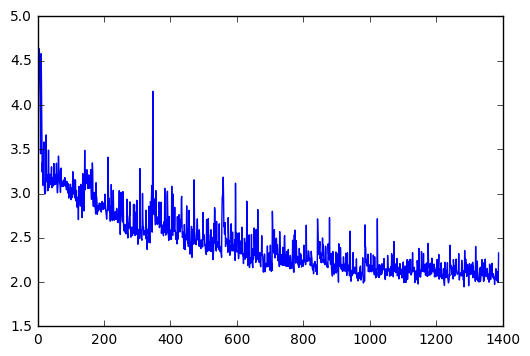

In [277]:
plt.plot(trainHist[:])

forward-feed:

In [255]:
prev = np.random.choice(vocab_size,num_steps).astype(np.float32).reshape(1,num_steps)
last_state = np.zeros((1, num_neurons),dtype=np.float32)

digital_shakespeare = []

for i in range(1000):
    pred, last_state = sess.run([prediction,final_state],feed_dict={x: prev, init_state: last_state})
    prev = np.argmax(pred,axis=2)
    digital_shakespeare += [rev_trans_dic[i] for i in prev.flatten().tolist()]

In [256]:
"".join(digital_shakespeare)

"EE(92\n)ILRU   \n \nE(T e,,s o        e S .I2\n rH TEnn2 ]t \nHmRRE\nYy ,Ue9. \na ohn,  I.HI.F     L\n o2NICTD29)   EOSC     \n2RO    tft       ahHd N)  eEPOR o I\nhh  eIIS   I S  \nW rgt   a   IC FI    E  n\nC,LIE)9 P  xR.LVW    \n RF   h hm      re  tE S  RHLICuh   ew rtC.B[  hoI  eCreht  rh   HOFROW  xtCo H IC\n 9BEh ou YIOCE    IIO  oweeo\n    eew hRChIWoEECEr c  rehrhL YT  awkt  r s  b oew  ERF.RIC ouErteB H  hIR IrrhoCNL.I     L  w  du     rr ha LeRN \nRLS.DohWoeiue OOROWh e t  hhm ohn  h xIL UZHBnt  hrr EB aRUIU  ew EI St    oCWhrE rw    oewevkOrITI \nOH Eue  dngdtRRSR. Irhhg aeefne w\nowetOCSEER hm aeosnEhn SNSI  e nTOCrhT  fKOee Iahw   rd ree     I   SCt,d\noer e I E T ee  tnd uesti t  h L.RNIBaemrdr     bhE CO  hooRL e O  iRdrt d  b  oeoosrt\n    hr hRr   t  hrh hxBhhrrs he osrt n h  awO IC.Udd   es\n   oe mORW  ur IOrhRI f\n ehtoh ohIrnur        aewe  g  hh oeecaeu   o aarsf   totew r  t H S  t   h    ndmyNIIOWrew .    Or  reh  tf    s w       rd rh\nhoToewfn hndsh  fhnt   

In [235]:
res = np.argmax(pred,axis=2)
res.flatten().shape

(20,)

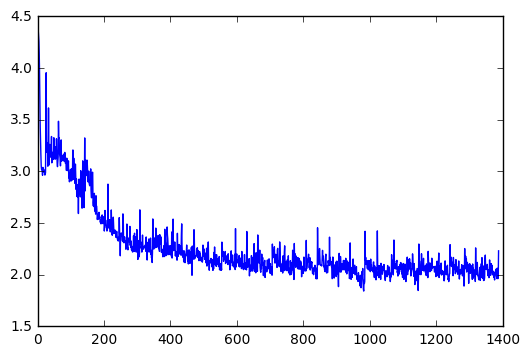

In [163]:
plt.plot(trainHist)

# Hyperparams:

In [140]:
grid = []
for learnRate in [0.0001,0.001,0.01,0.1]:

    optimizer = tf.train.AdamOptimizer(learning_rate=learnRate)
    trainOp = optimizer.minimize(loss)

    init_vars = tf.initialize_all_variables()
    trainHist = []
    with tf.Session() as sess:
        sess.run(init_vars)
        for epoch in gen_epochs(raw_text_enc[:],1,batch_size,num_steps):
            for i, batch in enumerate(epoch):
                lossVal, _ = sess.run([loss,trainOp],feed_dict={x: batch[0], y: batch[1]})
                trainHist.append(lossVal)

                if i % 100 == 0:
                    clear_output()
                    print(learnRate, i, lossVal)
    
    grid.append(trainHist)

(0.1, 1300, 2.0869632)


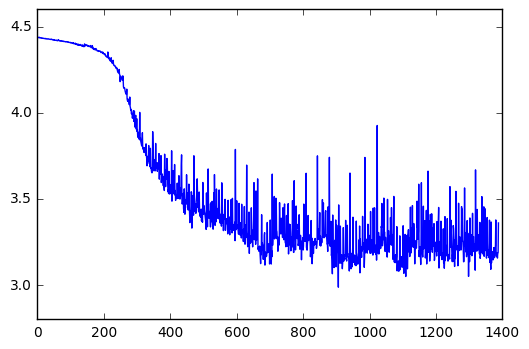

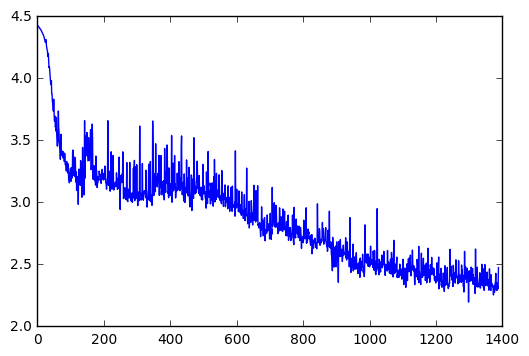

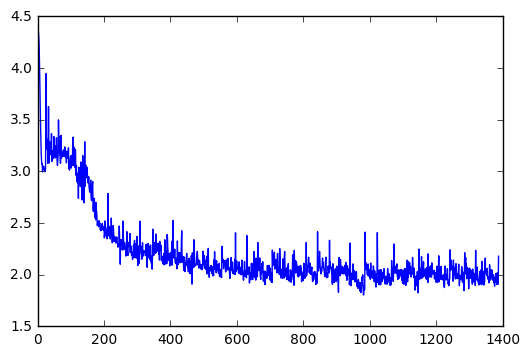

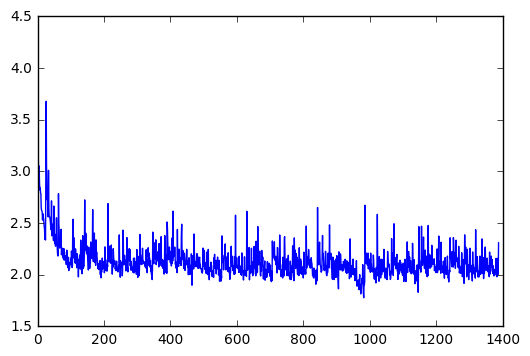

In [142]:
for i in range(4):
    plt.plot(grid[i])
    plt.show()